In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import os
import re
from scipy import signal
from matplotlib.dates import date2num
from matplotlib.collections import LineCollection
plt.rcParams['pdf.fonttype'] = 42

In [2]:
minimum_length = 50        # データレトリーブするときにこれ以下の長さの時系列は捨てる
minimum_cdk_peak = {"HS007": 1.7, "HS038": 1.7}      # ピークと検出されるために最低限必要なratio値
interval = 5        # 撮影間隔

dirs = sorted(glob.glob("./dir_HS*"))

data_stats = pd.DataFrame({})  # 分裂から分裂までの時間とか，時系列データじゃないデータを格納するdata frame
data_div_to_div = pd.DataFrame()     # 分裂から分裂までの時系列データを格納
data_tot_hm = pd.DataFrame({})
for dir_name in dirs:
    data_plot = pd.DataFrame({})
    data_plot_line = pd.DataFrame({})

    strain_name = dir_name[6:-4]
    stress = dir_name[-3:]

    # 各strainのデータを読み込む
    data_all = pd.read_csv(dir_name + "/_results.csv")
    lineage_org = data_all[" Lineage"].unique().tolist()  # 元データのLineage列に含まれる文字列： [ a_..._z ]を重複なく抜き出す

    # 個別のlineageとして全データをレトリーブする
    data_container1 = {}
    data_container2 = {}
    for cmp in lineage_org:
        df_RFP = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C0"]
        df_FRET = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C1"]
        df_CFP = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C2"]
        df_ratio = df_FRET / df_CFP
        data_container1[cmp[2:-2]] = df_ratio  # 元の[ a_..._z ]ではなく，a_..._zを抜き出して辞書data_containerに格納
        data_container2[cmp[2:-2]] = df_RFP  # 元の[ a_..._z ]ではなく，a_..._zを抜き出して辞書data_containerに格納
    container_keys = sorted(data_container1.keys(), reverse=True)
    for cmp in container_keys:
        if cmp[-2:] != "_2":  # 末尾に_2がついてるやつのみ処理する
            continue
        # xxx_2 vs xxx_1を比べて長くトラッキングできてるほうを根元の時系列データにつなげる
        if len(data_container1[cmp]) > len(data_container1[cmp[:-2] + "_1"]):
            data_container1[cmp[:-2]] = pd.concat([data_container1[cmp[:-2]], data_container1[cmp]],
                                                 ignore_index=True)
            data_container2[cmp[:-2]] = pd.concat([data_container2[cmp[:-2]], data_container2[cmp]],
                                                  ignore_index=True)
        else:
            data_container1[cmp[:-2]] = pd.concat([data_container1[cmp[:-2]], data_container1[cmp[:-2] + "_1"]],
                                                 ignore_index=True)
            data_container2[cmp[:-2]] = pd.concat([data_container2[cmp[:-2]], data_container2[cmp[:-2] + "_1"]],
                                                 ignore_index=True)

    # 上の操作によって" _ "のついていない根元の細胞から辿れた最大のトラッキングデータが繋げられている
    lineages_ratio = pd.DataFrame({})  # ここに統合した最長のcell lineageのdf-ratioを格納していく．
    lineages_RFP = pd.DataFrame({})  # ここに統合した最長のcell lineageのdf-RFPを格納していく．
    for cmp in container_keys:
        if "_" in cmp:  # origin cellじゃなければ処理しない
            continue
        if len(data_container1[cmp]) < minimum_length:  # 一定の長さ以下の細胞は見ても仕方がないので除く．
            continue
        start_imgNo = min(data_all.loc[data_all[" Lineage"] == "[ " + cmp + " ]", " ImgNo"])
        if start_imgNo == 0:
            temp = pd.DataFrame({cmp: [k for k in data_container1[cmp]]})
        else:
            temp1 = [np.nan for k in range(start_imgNo)]
            temp1.extend([k for k in data_container1[cmp]])
            temp = pd.DataFrame({cmp: [k for k in temp1]})

        lineages_ratio = pd.concat([lineages_ratio, temp], axis="columns")

        if start_imgNo == 0:
            temp = pd.DataFrame({cmp: [k for k in data_container2[cmp]]})
        else:
            temp1 = [np.nan for k in range(start_imgNo)]
            temp1.extend([k for k in data_container2[cmp]])
            temp = pd.DataFrame({cmp: [k for k in temp1]})

        lineages_RFP = pd.concat([lineages_RFP, temp], axis="columns")

    # ここまででlineagesの中に，すべてのoriginの細胞のFRET ratioの時系列データが記録された．列番号が細胞の番号に対応する．
    # CDK活性のピークを検出する．
    count = 0
    for cell_name in lineages_ratio:
        ratio = [i for i in lineages_ratio[cell_name]]
        RFP = [i for i in lineages_RFP[cell_name]]
        maximas = [int(i) for i in signal.argrelmax(np.array(ratio), order=10)[0] if
                   ratio[int(i)] > minimum_cdk_peak[strain_name]]

        # 全時系列データをヒートマップ用に成形する．具体的には，刺激後のCDKの活性でソートする．
        max_val_ratio = max(ratio)
        min_val_ratio = min(ratio)
        ratio_norm = [(cmp - min_val_ratio) / (max_val_ratio - min_val_ratio) for cmp in ratio]

        max_val_RFP = max(RFP)
        min_val_RFP = min(RFP)
        RFP_norm = [(cmp - min_val_RFP) / (max_val_RFP - min_val_RFP) for cmp in RFP]
        if stress == "dox" and strain_name == "HS007":
            temp = pd.DataFrame(
            [[3 * k for k in range(len(ratio))], ratio, ratio_norm, RFP, RFP_norm,
             [cell_name for j in range(len(ratio))], [strain_name for j in range(len(ratio))], [np.mean(RFP[76:81]) for k in range(len(ratio))], [stress for j in range(len(ratio))]],
            index=["time", "CDKEV-raw", "CDKEV-norm", "RFP-raw", "RFP-norm", "cell", "strain", "RFP-at-stimuli", "stress"])
        else:
            temp = pd.DataFrame(
            [[5 * k for k in range(len(ratio))], ratio, ratio_norm, RFP, RFP_norm,
             [cell_name for j in range(len(ratio))], [strain_name for j in range(len(ratio))], [np.mean(RFP[46:49]) for k in range(len(ratio))], [stress for j in range(len(ratio))]],
            index=["time", "CDKEV-raw", "CDKEV-norm", "RFP-raw", "RFP-norm", "cell", "strain", "RFP-at-stimuli", "stress"])
        data_tot_hm = pd.concat([data_tot_hm, temp.T])


In [3]:
# 回収した元データをcsv形式で吐き出す．
data_tot_hm.to_csv("./_total_time-course.csv")


In [4]:
cmap = sns.color_palette()
cmap_hm = "plasma"

data_tot_hm = pd.read_csv("./_total_time-course.csv", index_col=0)
#data_div_to_div = pd.read_csv("./_div_to_div.csv", index_col=0)
#data_stats = pd.read_csv("./_stats.csv", index_col=0)

print(data_tot_hm)

strains = sorted(data_tot_hm["strain"].unique().tolist())  # strainを重複なく抜き出す
stresses = sorted(data_tot_hm["stress"].unique().tolist())  # stress sourceを重複なく抜き出す
for cmp in strains_to_omit:
    if cmp in strains:
        strains.remove(cmp)     # plotに使いたくないやつを除く

     time  CDKEV-raw  CDKEV-norm     RFP-raw  RFP-norm  cell strain  \
0       0   1.626299    0.370664  346.015385  0.859543    99  HS007   
1       3   1.633641    0.384558  337.118110  0.833846    99  HS007   
2       6   1.641941    0.400265  355.119048  0.885835    99  HS007   
3       9   1.645489    0.406980  368.140625  0.923444    99  HS007   
4      12   1.644619    0.405335  367.419847  0.921362    99  HS007   
..    ...        ...         ...         ...       ...   ...    ...   
195   975        NaN         NaN         NaN       NaN     1  HS038   
196   980        NaN         NaN         NaN       NaN     1  HS038   
197   985        NaN         NaN         NaN       NaN     1  HS038   
198   990        NaN         NaN         NaN       NaN     1  HS038   
199   995        NaN         NaN         NaN       NaN     1  HS038   

     RFP-at-stimuli stress  
0               NaN    dox  
1               NaN    dox  
2               NaN    dox  
3               NaN    dox  
4 

dox HS007
dox HS038
osm HS007
osm HS038
oxi HS007
oxi HS038


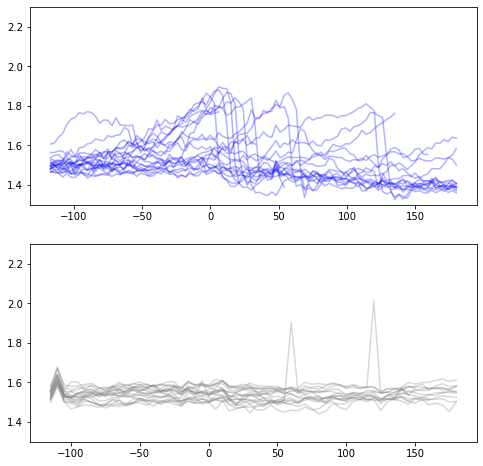

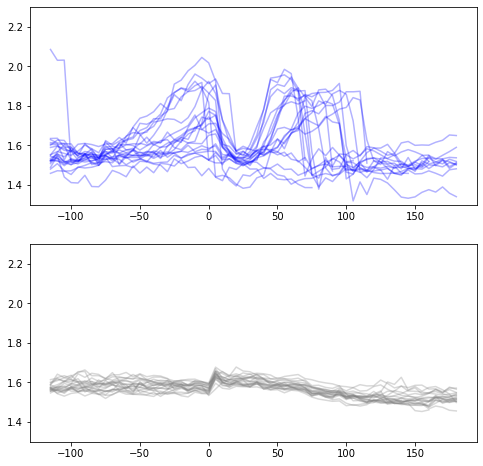

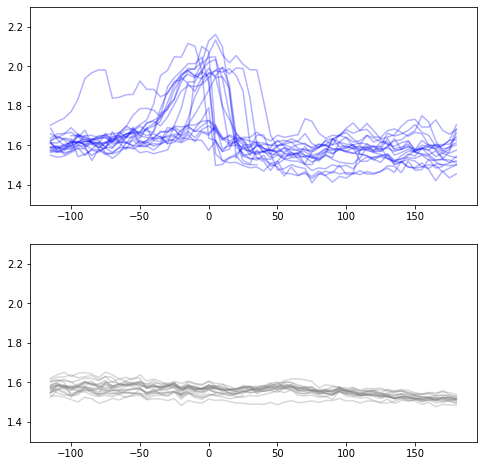

In [19]:
# CDK activityを刺激時のRFPが高い順に20細胞ずつプロット。
# 刺激前後の5時間くらい

hm_length = 160
data_plot_scatter = pd.DataFrame({})
for l in range(len(stresses)):
    stress = stresses[l]
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    for k in range(len(strains)):
        strain = strains[k]
        plt_color = ["blue", "grey"][k]

        data_temp = data_tot_hm.loc[(data_tot_hm["strain"] == strain) & (data_tot_hm["stress"] == stress) & (data_tot_hm["time"] < 421) & (data_tot_hm["time"] > 121), ["time", "CDKEV-raw", "RFP-raw", "RFP-at-stimuli", "cell"]]
        sort_keys = sorted(data_temp["RFP-at-stimuli"].unique().tolist(), reverse=True)
        sort_keys = [x for x in sort_keys if not np.isnan(x)][:20]
        # 刺激時のRFPが高い順に20細胞くらいプロットしてみる
        print(stress, strain)
        for cmp in sort_keys:
            df_plot = data_temp.loc[data_temp["RFP-at-stimuli"] == cmp]
            df_plot = df_plot.sort_values("time")
            x = df_plot["time"] - 240
            y = df_plot["CDKEV-raw"]
            ax[k].plot(x, y, alpha=0.3, color=plt_color)
            #ax.vlines(240, 1.3, 2.3, color="black")
    #plt.xlim(120, 420)
    ax[0].set_ylim(1.3, 2.3)
    ax[1].set_ylim(1.3, 2.3)
    plt.savefig("./_results_" + stress + "_20_short.png")
    plt.savefig("./_results_" + stress + "_20_short.pdf")
    

34
dox HS007
20
dox HS038
29
osm HS007
29
osm HS038
31
oxi HS007
31
oxi HS038


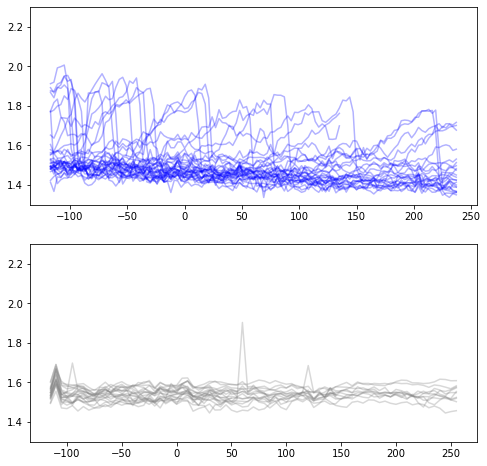

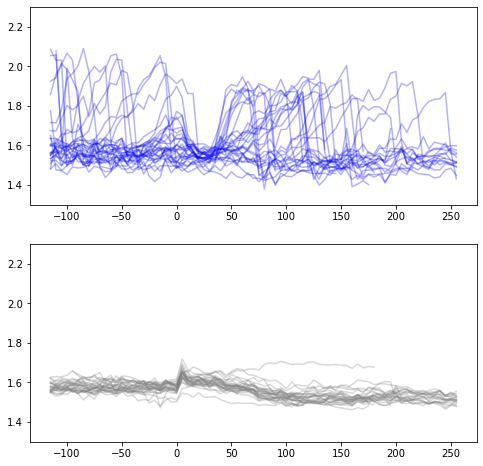

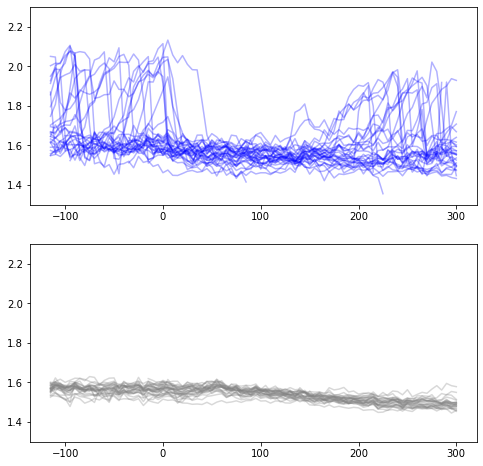

In [20]:
# CDK activityを刺激時のRFPが高い順に並べてそれを3細胞ずつピックアップ。
# 刺激前後の7時間くらい

hm_length = 160
data_plot_scatter = pd.DataFrame({})
for l in range(len(stresses)):
    stress = stresses[l]
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    for k in range(len(strains)):
        strain = strains[k]
        plt_color = ["blue", "grey"][k]

        data_temp = data_tot_hm.loc[(data_tot_hm["strain"] == strain) & (data_tot_hm["stress"] == stress) & (data_tot_hm["time"] < 541) & (data_tot_hm["time"] > 121), ["time", "CDKEV-raw", "RFP-raw", "RFP-at-stimuli", "cell"]]
        sort_keys = sorted(data_temp["RFP-at-stimuli"].unique().tolist(), reverse=True)
        sort_keys = [x for x in sort_keys if not np.isnan(x)][::3]
        print(len(sort_keys))
        # 刺激時のRFPが高い順に20細胞くらいプロットしてみる
        print(stress, strain)
        for cmp in sort_keys:
            df_plot = data_temp.loc[data_temp["RFP-at-stimuli"] == cmp]
            df_plot = df_plot.sort_values("time")
            x = df_plot["time"] - 240
            y = df_plot["CDKEV-raw"]
            ax[k].plot(x, y, alpha=0.3, color=plt_color)
            #ax.vlines(240, 1.3, 2.3, color="black")
    #plt.xlim(120, 420)
    ax[0].set_ylim(1.3, 2.3)
    ax[1].set_ylim(1.3, 2.3)
    plt.ylim(1.3, 2.3)
    plt.savefig("./_results_" + stress + "_sparse_long.png")
    plt.savefig("./_results_" + stress + "_sparse_long.pdf")
    

dox HS007
dox HS038
osm HS007
osm HS038
oxi HS007
oxi HS038


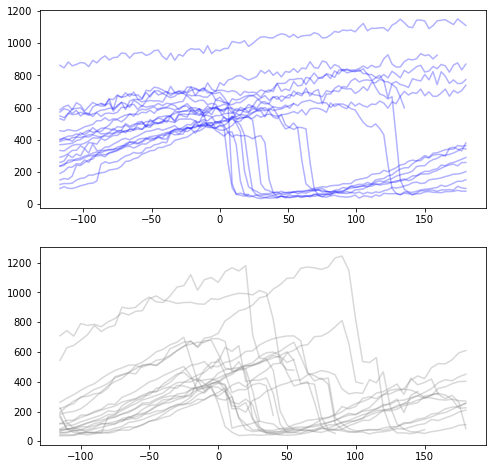

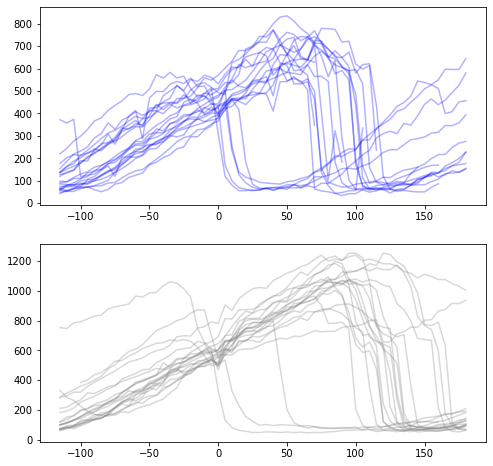

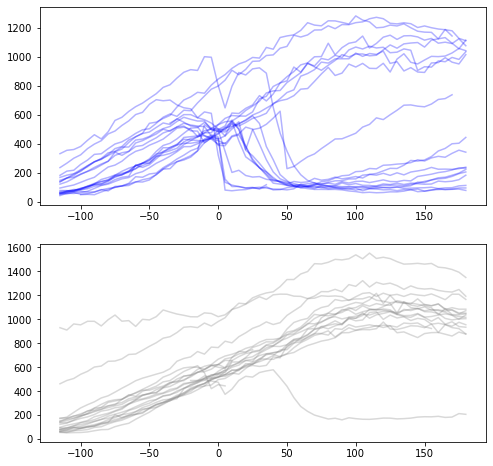

In [16]:
# cyclinを刺激時のRFPが高い順に20細胞ずつプロット。
# 刺激前後の5時間くらい

hm_length = 160
data_plot_scatter = pd.DataFrame({})
for l in range(len(stresses)):
    stress = stresses[l]
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    for k in range(len(strains)):
        strain = strains[k]
        plt_color = ["blue", "grey"][k]

        data_temp = data_tot_hm.loc[(data_tot_hm["strain"] == strain) & (data_tot_hm["stress"] == stress) & (data_tot_hm["time"] < 421) & (data_tot_hm["time"] > 121), ["time", "CDKEV-raw", "RFP-raw", "RFP-at-stimuli", "cell"]]
        sort_keys = sorted(data_temp["RFP-at-stimuli"].unique().tolist(), reverse=True)
        sort_keys = [x for x in sort_keys if not np.isnan(x)][:20]
        # 刺激時のRFPが高い順に20細胞くらいプロットしてみる
        print(stress, strain)
        for cmp in sort_keys:
            df_plot = data_temp.loc[data_temp["RFP-at-stimuli"] == cmp]
            df_plot = df_plot.sort_values("time")
            x = df_plot["time"] - 240
            y = df_plot["RFP-raw"]
            ax[k].plot(x, y, alpha=0.3, color=plt_color)
            #ax.vlines(240, 1.3, 2.3, color="black")
    #plt.xlim(120, 420)
    #plt.ylim(1.3, 2.3)
    plt.savefig("./_results_" + stress + "_20_short_cyclin.png")
    plt.savefig("./_results_" + stress + "_20_short_cyclin.pdf")
    

34
dox HS007
20
dox HS038
29
osm HS007
29
osm HS038
31
oxi HS007
31
oxi HS038


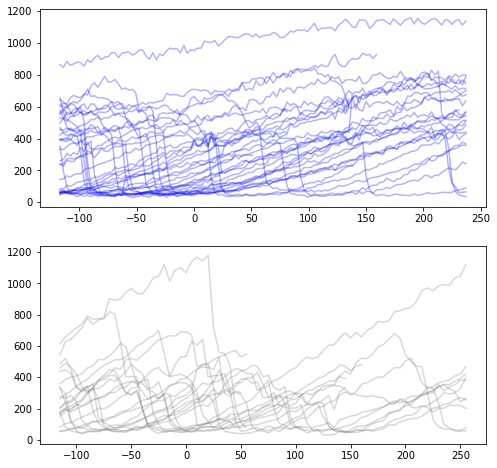

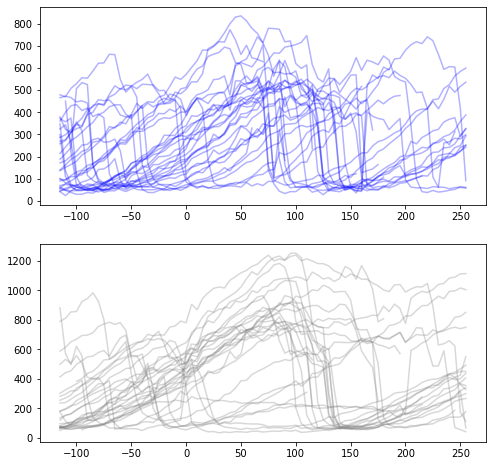

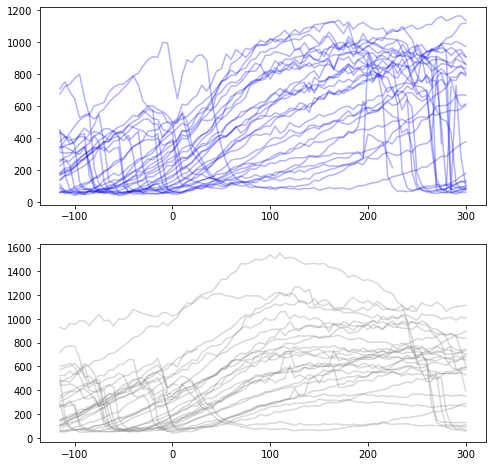

In [17]:
# cyclinを刺激時のRFPが高い順に並べて3細胞ずつピックアップ。
# 刺激前後の7時間くらい

hm_length = 160
data_plot_scatter = pd.DataFrame({})
for l in range(len(stresses)):
    stress = stresses[l]
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    for k in range(len(strains)):
        strain = strains[k]
        plt_color = ["blue", "grey"][k]

        data_temp = data_tot_hm.loc[(data_tot_hm["strain"] == strain) & (data_tot_hm["stress"] == stress) & (data_tot_hm["time"] < 541) & (data_tot_hm["time"] > 121), ["time", "CDKEV-raw", "RFP-raw", "RFP-at-stimuli", "cell"]]
        sort_keys = sorted(data_temp["RFP-at-stimuli"].unique().tolist(), reverse=True)
        sort_keys = [x for x in sort_keys if not np.isnan(x)][::3]
        print(len(sort_keys))
        # 刺激時のRFPが高い順に20細胞くらいプロットしてみる
        print(stress, strain)
        for cmp in sort_keys:
            df_plot = data_temp.loc[data_temp["RFP-at-stimuli"] == cmp]
            df_plot = df_plot.sort_values("time")
            x = df_plot["time"] - 240
            y = df_plot["RFP-raw"]
            ax[k].plot(x, y, alpha=0.3, color=plt_color)
            #ax.vlines(240, 1.3, 2.3, color="black")
    #plt.xlim(120, 420)
    #plt.ylim(1.3, 2.3)
    plt.savefig("./_results_" + stress + "_sparse_long_cyclin.png")
    plt.savefig("./_results_" + stress + "_sparse_long_cyclin.pdf")
    

In [ ]:
# heatmapで全データをプロット．
hm_length = 160
data_plot_scatter = pd.DataFrame({})
for l in range(len(stresses)):
    for k in range(len(strains)):
        data_plot_heatmap = pd.DataFrame({})
        data_plot_heatmap_RFP = pd.DataFrame({})

        strain = strains[k]
        stress = stresses[k]
        data_temp = data_tot_hm.loc[(data_tot_hm["strain"] == strain) & (data_tot_hm["stress"] == stress), ["time", "CDKEV-raw", "RFP-raw", "RFP-at-stimuli", "cell"]]
        sort_keys = data_temp["RFP-at-stimuli"].unique().tolist()  # first-durationを重複なく抜き出す
        sort_keys = sorted([float(k) for k in sort_keys if not np.isnan(k)])
        data_plot_heatmap["cell-0000"] = [np.NaN for k in range(hm_length)]
        data_plot_heatmap_RFP["cell-0000"] = [np.NaN for k in range(hm_length)]
        for cmp in sort_keys:
            cells_to_plot = data_temp.loc[(data_temp["RFP-at-stimuli"] == cmp), "cell"].unique().tolist()
            for cell in cells_to_plot:
                temp = data_temp.loc[data_temp["cell"] == cell]["CDKEV-raw"].astype("float64")
                if np.isnan(temp[30]) or np.isnan(temp[130]):
                    continue
                data_plot_heatmap["cell-" + str(cell)] = temp[:160]
                temp2 = data_temp.loc[data_temp["cell"] == cell]["RFP-raw"].astype("float64")
                data_plot_heatmap_RFP["cell-" + str(cell)] = temp2[:160]

                temp_scatter = pd.DataFrame([temp[41:81].tolist(), temp2[41:81].tolist(), [cell for j in range(40)], ["before" for j in range(40)]],
                                            index=["ratio", "cyclin", "cell", "period"])
                data_plot_scatter = pd.concat([data_plot_scatter, temp_scatter.T], ignore_index=True)
                temp_scatter = pd.DataFrame([temp[81:91].tolist(), temp2[81:91].tolist(), [cell for j in range(10)], ["during adaptation" for j in range(10)]],
                                            index=["ratio", "cyclin", "cell", "period"])
                data_plot_scatter = pd.concat([data_plot_scatter, temp_scatter.T], ignore_index=True)
                temp_scatter = pd.DataFrame([temp[91:131].tolist(), temp2[91:131].tolist(), [cell for j in range(40)], ["after" for j in range(40)]],
                                            index=["ratio", "cyclin", "cell", "period"])
                data_plot_scatter = pd.concat([data_plot_scatter, temp_scatter.T], ignore_index=True)

        fig = plt.figure(figsize=(8, 8))
        data_plot_scatter["ratio"] = data_plot_scatter["ratio"].astype(float)
        data_plot_scatter["cyclin"] = data_plot_scatter["cyclin"].astype(float)
        sort_keys = data_plot_scatter["period"].unique().tolist()  # first-durationを重複なく抜き出す
        for cmp in sort_keys:
            temp = data_plot_scatter.loc[data_plot_scatter["period"] == cmp]
            sns.kdeplot(x="cyclin", y="ratio", data=temp, legend=False)
        plt.xlim(-200, 1600)
        plt.ylim(1.3, 2.2)
        plt.savefig("./__scatter_" + strain + "_distribution.pdf", transparent=False)
        plt.show()

        fig = plt.figure(figsize=(8, 6))
        sns.scatterplot(x="cyclin", y="ratio", data=data_plot_scatter, hue="period")
        fig.savefig("./__scatter_" + strain + ".pdf", transparent=False)
        plt.show()

        fig = plt.figure(figsize=(12, 6))
        sns.heatmap(data_plot_heatmap.T, cmap=cmap_hm, vmax=2.2, vmin=1.3)
        fig.savefig("./__heatmap_" + strain + "_CDKEV.pdf", transparent=False)
        plt.show()

        fig = plt.figure(figsize=(12, 6))
        sns.heatmap(data_plot_heatmap_RFP.T, cmap=cmap_hm, vmax=1600, vmin=0)
        fig.savefig("./__heatmap_" + strain + "_cdc13.pdf", transparent=False)
        plt.show()

In [ ]:
# 分裂時間の分布に関するプロットを作る
fig = plt.figure(figsize=(8, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.violinplot(x="strain", y="cell-cycle-length", data=data_temp, color="lightgray", jitter=False)
sns.swarmplot(x="strain", y="cell-cycle-length", data=data_temp, hue="strain")
plt.savefig("./__cycle-length_distribution.png")
plt.close(fig)

fig = plt.figure(figsize=(8, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.violinplot(x="strain", y="cdk-at-div", data=data_temp, color="lightgray", jitter=False)
sns.swarmplot(x="strain", y="cdk-at-div", data=data_temp, hue="strain")
plt.savefig("./__cdk_distribution.png")
plt.close(fig)

fig = plt.figure(figsize=(8, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.scatterplot(x="cell-cycle-length", y="cell-cycle-length_next", data=data_temp, hue="strain")
plt.savefig("./__relations-of-cycletime-over-generation.png")
plt.close(fig)

fig = plt.figure(figsize=(8, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
data_temp["cell-cycle-length-ratio"] = data_temp["cell-cycle-length_next"] / data_temp["cell-cycle-length"]
sns.scatterplot(x="cell-cycle-length", y="cell-cycle-length-ratio", data=data_temp, hue="strain")
plt.savefig("./__relations-of-cycletime-over-generation2.png")
plt.close(fig)

for cmp in strains:
    data_temp2 = data_temp.loc[data_temp["strain"] == cmp]
    corrs = data_temp2.corr()
    corrs.to_csv("./__stats_corr_" + cmp + ".csv")

fig = plt.figure(figsize=(8, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.scatterplot(x="cdk-at-div", y="cell-cycle-length", data=data_temp, hue="strain")
plt.savefig("./__relations-of-cdk-vs-cycletime.png")
plt.close(fig)
mean = data_temp.groupby("strain")["cdk-at-div"].mean()
std = data_temp.groupby("strain")["cdk-at-div"].std()
cv = [k for k in std/mean]
mean = [k for k in mean]
print(cv, mean)

fig = plt.figure(figsize=(8, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.scatterplot(x="cdk-at-2nd-div", y="cell-cycle-length", data=data_temp, hue="strain")
plt.xlim(1.7, 2.2)
plt.savefig("./__relations-of-cdk2nd-vs-cycletime.png")
plt.close(fig)

fig = plt.figure(figsize=(8, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.scatterplot(x="cdk-at-div", y="cdk-at-2nd-div", data=data_temp, hue="strain")
plt.xlim(1.7, 2.2)
plt.ylim(1.7, 2.2)
plt.savefig("./__relations-of-cdk-over-generation.png")
plt.close(fig)
